In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as special
import scipy.optimize as optimize
from typing import List, Tuple
import plotly.graph_objects as go
import plotly.subplots as make_subplots
from guassian_beam import *

## Data Pre-Processing

In [2]:
# File Paths: *CHANGE THIS*
PATH_1 = 'Coupler_Beam_Width_data.xlsx'
PATH_2 = 'HeNe_Beam_Width_Data.xlsx'

# Load in Data: You may have to change the columns depending on the data format
coupler_data = pd.read_excel(PATH_1, usecols=[2,1])
hene_data = pd.read_excel(PATH_2, usecols=[2,1])

# Convert W to mW: could be different if you used another unit
coupler_data['Intensity (W)'] = coupler_data['Intensity (W)'] * 10**3
hene_data['Intensity (W)'] = hene_data['Intensity (W)'] * 10**3

# Convert um to mm: could be different if you used another unit
coupler_data['Position (um)'] = coupler_data['Position (um)'] * 10**-3
hene_data['Position (um)'] = hene_data['Position (um)'] * 10**-3

# Rename Columns
coupler_data.rename(columns={'Intensity (W)': 'Intensity (mW)'}, inplace=True)
hene_data.rename(columns={'Intensity (W)': 'Intensity (mW)'}, inplace=True)
coupler_data.rename(columns={'Position (um)': 'Position (mm)'}, inplace=True)
hene_data.rename(columns={'Position (um)': 'Position (mm)'}, inplace=True)

print(coupler_data)
print(hene_data)

     Intensity (mW)  Position (mm)
0             0.370           0.00
1             0.368           0.02
2             0.366           0.04
3             0.366           0.06
4             0.367           0.08
..              ...            ...
185           0.010           3.70
186           0.010           3.72
187           0.010           3.74
188           0.010           3.76
189           0.010           3.78

[190 rows x 2 columns]
    Intensity (mW)  Position (mm)
0             3.95           0.00
1             3.95           0.02
2             3.93           0.04
3             3.91           0.06
4             3.89           0.08
..             ...            ...
57            0.04           1.14
58            0.04           1.16
59            0.03           1.18
60            0.03           1.20
61            0.03           1.22

[62 rows x 2 columns]


## Plot Data

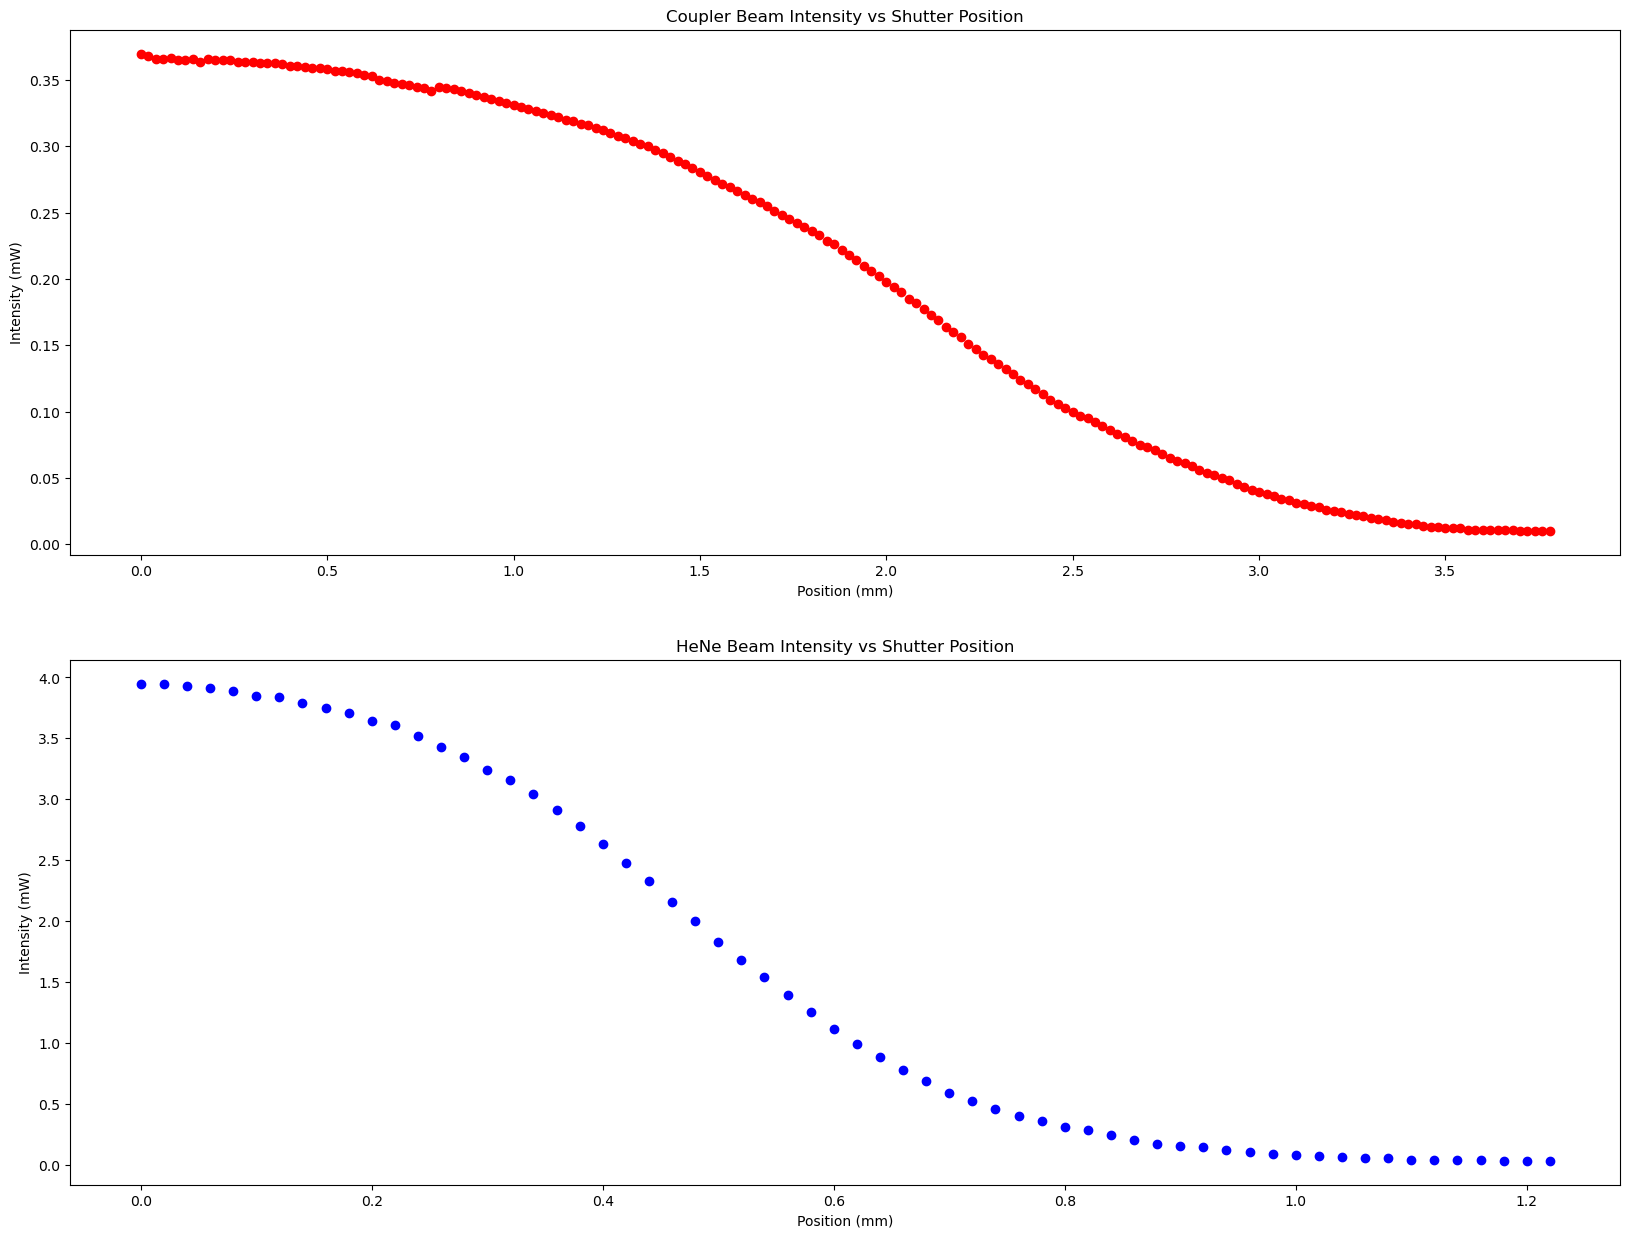

In [3]:
x1 = coupler_data['Position (mm)']
y1 = coupler_data['Intensity (mW)']
x2 = hene_data['Position (mm)']
y2 = hene_data['Intensity (mW)']

plt.figure(figsize=(20,15))

# Coupler Data
plt.subplot(2,1,1)
plt.scatter(x1, y1, color='r')
plt.title('Coupler Beam Intensity vs Shutter Position')
plt.xlabel('Position (mm)')
plt.ylabel('Intensity (mW)')

# HeNe Data
plt.subplot(2,1,2)
plt.scatter(x2, y2, color='b')
plt.title('HeNe Beam Intensity vs Shutter Position')
plt.xlabel('Position (mm)')
plt.ylabel('Intensity (mW)')

plt.show()

## Fit the Experimental Data With the erfc Model

In [ ]:
# Coupler data
initial_guess = [0.01, 0.35, 2, 1]
coupler_parameters = fit_data(guassian_beam_erfc, x1, y1, initial_guess)
coupler_fit = guassian_beam_erfc(x1, *coupler_parameters[0])

# HeNe data
initial_guess = [0.01, 4, 0.5, 0.4]
hene_parameters = fit_data(guassian_beam_erfc, x2, y2, initial_guess)
hene_fit = guassian_beam_erfc(x2, *hene_parameters[0])


## Graph Data and Fit Superimposed

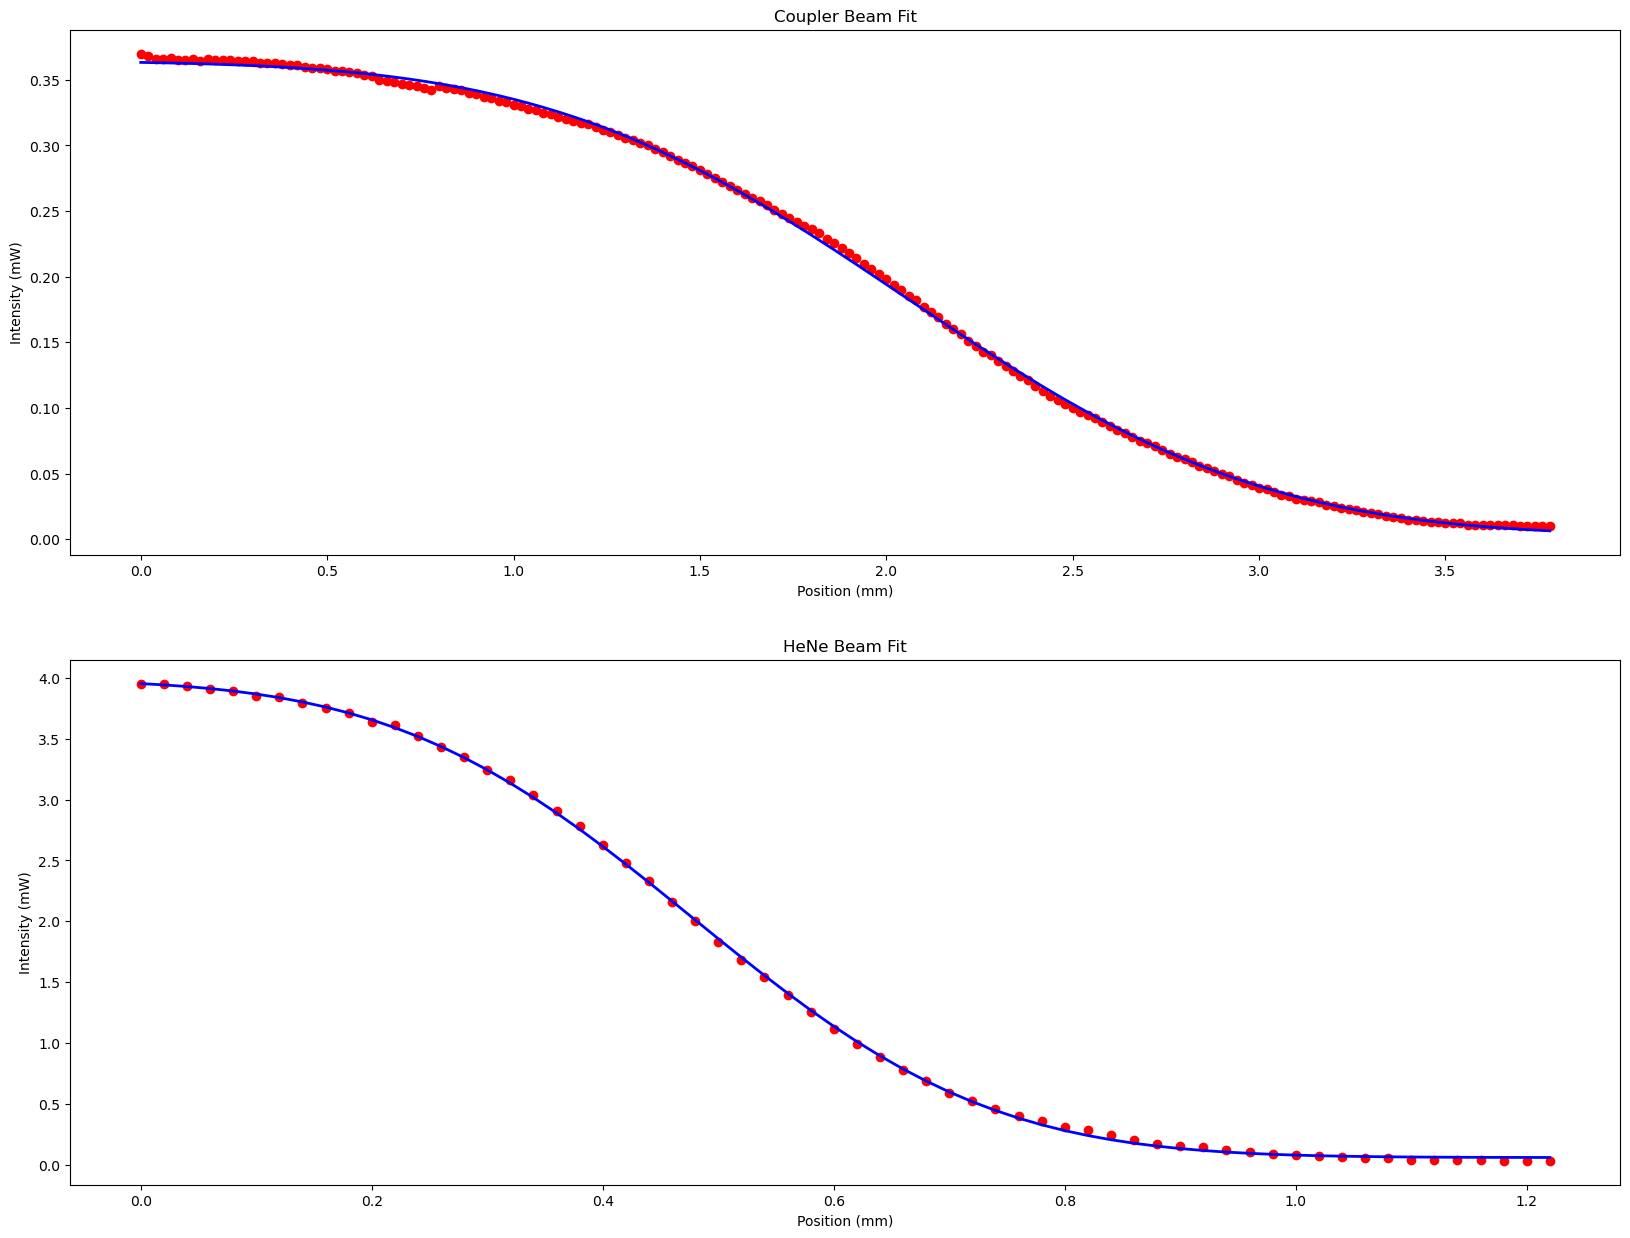

In [5]:
plt.figure(figsize=(20,15))

plt.subplot(2,1,1)
plt.scatter(x1, y1, label='Data', color='r')
plt.plot(x1, coupler_fit, label='Fit', color='b', lw=2)
plt.xlabel('Position (mm)')
plt.ylabel('Intensity (mW)')
plt.title('Coupler Beam Fit')

plt.subplot(2,1,2)
plt.scatter(x2, y2, label='Data', color='r')
plt.plot(x2, hene_fit, label='Fit', color='b', lw=2)
plt.xlabel('Position (mm)')
plt.ylabel('Intensity (mW)')
plt.title('HeNe Beam Fit')

plt.show()

## Create Param Table

In [6]:
fit_parameters = pd.DataFrame({'Coupler': coupler_parameters[0], 'HeNe': hene_parameters[0]},
                              index=['Power Offset (mW)', 'Max Power (mW)', 'Half Power position (mm)', 'Beam Radius (mm)'])

param_table = go.Figure(data=[go.Table(
    header=dict(values=['Parameter', 'Coupler', 'HeNe'],
                fill_color='paleturquoise',
                align='left',
                height=40,
                font={"size": 15}),
    cells=dict(values=[fit_parameters.index, fit_parameters['Coupler'], fit_parameters['HeNe']],
                fill_color='lavender',
                align='left',
                height=30,
                font={"size": 12}))
])

param_table.show()

## Show Covarience Matrices to Identify Error

In [7]:
coupler_cov_matrix = coupler_parameters[1]
coupler_cov_df = pd.DataFrame(coupler_cov_matrix, columns=['Power Offset', 'Max Power', 'Half Power position', 'Beam Radius'], index=['p_offset', 'p_max', 'x_half', 'w'])

hene_cov_matrix = hene_parameters[1]
hene_cov_df = pd.DataFrame(hene_cov_matrix, columns=['Power Offset', 'Max Power', 'Half Power position', 'Beam Radius'], index=['p_offset', 'p_max', 'x_half', 'w'])

cov_table = go.Figure(data=[go.Table(
    header=dict(values=['','p_offset', 'p_max', 'x_half', 'w'],
                fill_color='lavender',
                align='left',
                height=40,
                font={"size": 12}),
    cells=dict(values=[coupler_cov_df.index, coupler_cov_df['Power Offset'], coupler_cov_df['Max Power'], coupler_cov_df['Half Power position'], coupler_cov_df['Beam Radius']],
               fill_color='lavender',
               align='left',
               height=30,
               font={"size": 12}))
])

hene_cov_table = go.Figure(data=[go.Table(
    header=dict(values=['','p_offset', 'p_max', 'x_half', 'w'],
                fill_color='lavender',
                align='left',
                height=40,
                font={"size": 12}),
    cells=dict(values=[hene_cov_df.index, hene_cov_df['Power Offset'], hene_cov_df['Max Power'], hene_cov_df['Half Power position'], hene_cov_df['Beam Radius']],
               fill_color='lavender',
               align='left',
               height=30,
               font={"size": 12}))
])

cov_table.show()
hene_cov_table.show()